<a href="https://colab.research.google.com/github/AilingLiu/property_price_prediction/blob/master/housing_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# set up

In [0]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= '0.2'

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# to plot properly
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [0]:
# where to save figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'HOUSING'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, 'IMAGES')
if not os.path.isdir(IMAGES_PATH):
  os.makedirs(IMAGES_PATH)

# saving figures helper
def save_fig(figure_name, path=IMAGES_PATH, dpi=300, tight_layout=True, format='png'):
  figure_path=os.path.join(path, figure_name+'.'+format)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(figure_path, dpi=dpi, format=format)

# where to save data
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, 'DATASETS')


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# get data

In [0]:
import urllib

url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'

def fetch_data(url=url, path=DATA_PATH):
  if not os.path.isdir(path):
    os.makedirs(path)
  file_path = os.path.join(path, 'housing.csv')
  urllib.request.urlretrieve(url, file_path)
  print(f'Your file is downloaded in: \n{file_path}')

In [19]:
fetch_data()

Your file is downloaded in: 
./HOUSING/DATASETS/housing.csv


In [20]:
!head -n 3 'HOUSING/DATASETS/housing.csv'

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


In [0]:
def load_data(path=DATA_PATH):
  csv_path=os.path.join(path, 'housing.csv')
  return pd.read_csv(csv_path)

In [23]:
housing = load_data()
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


# A quick look of data structure

In [24]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


This dataset contains 20640 rows, not a large dataset. It has 10 attributes. One of the attributes `total_bedrooms` has a small amount of missing values. 

One categorical attribute, and the rest are numerical attributes.

In [25]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can see the last few attributes starting from `total_rooms` to `median_house_value` are highly skewed, since 75% threshold value is way from maximum values. We can check their distribution status by histogram.

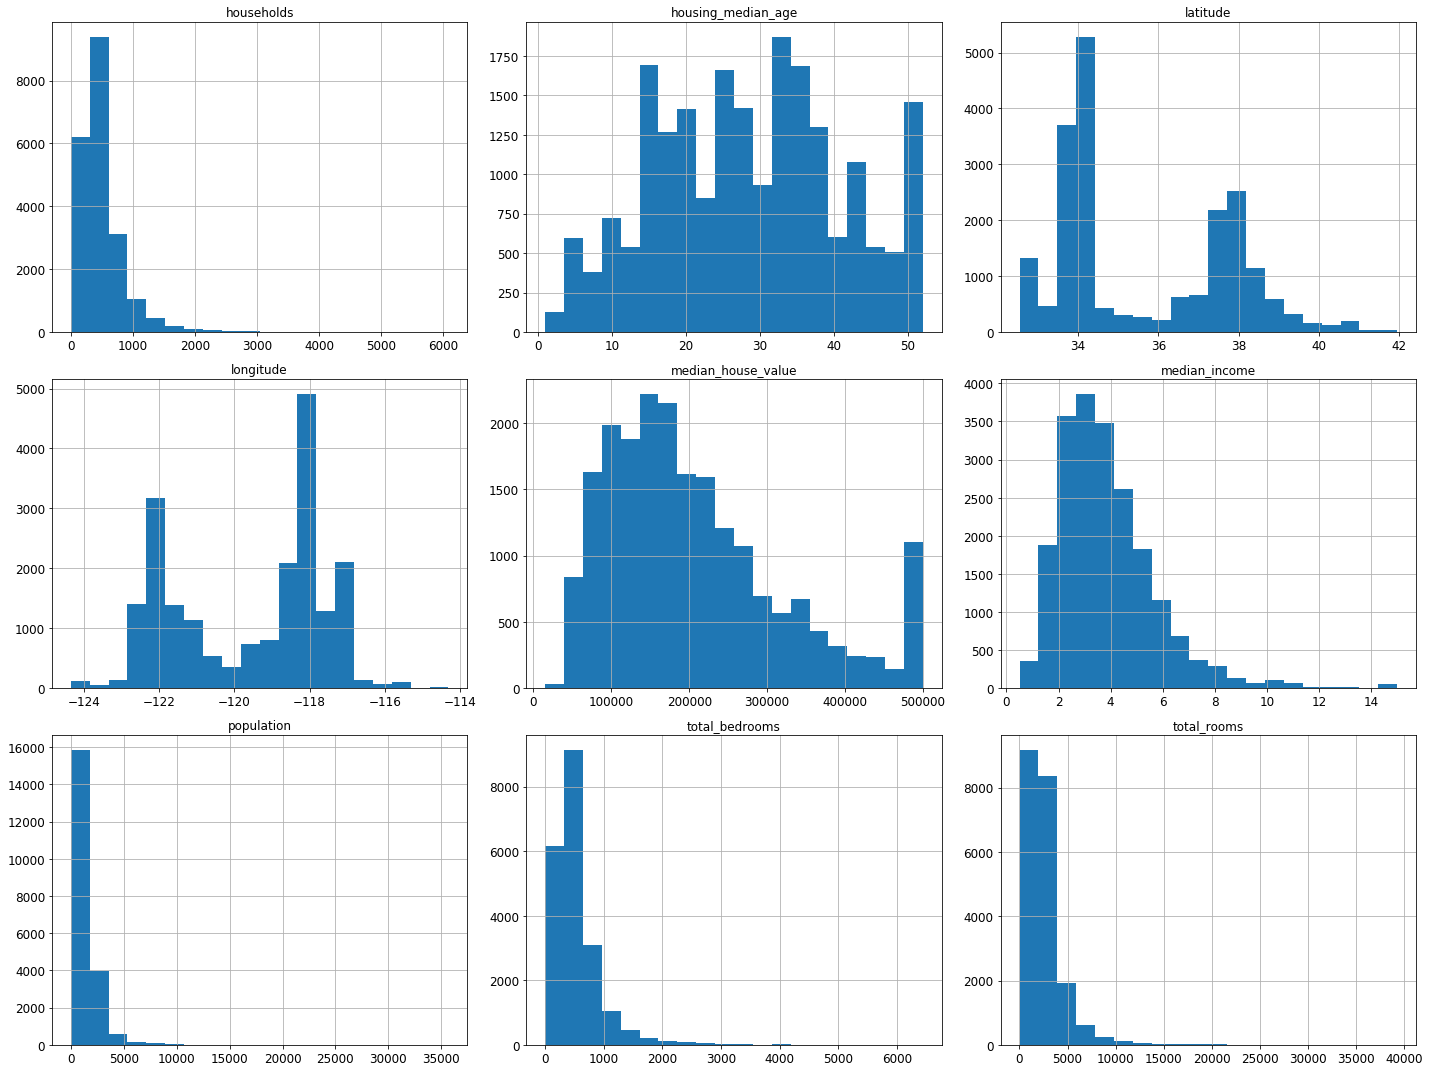

In [31]:
housing.hist(bins=20, figsize=(20, 15))
save_fig('housing_numerical_features_histogram_plot')

notes:

1. what's the unit of `median_income`? Any cap?
2. `median_house_value` seems capped?
3. Attributes have different scale
4. Most attributes are tail heavy
5. `longtitude` and `latitude` are bi-modal, which means there are two to four regions dominating the datasets.


# create test set

In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

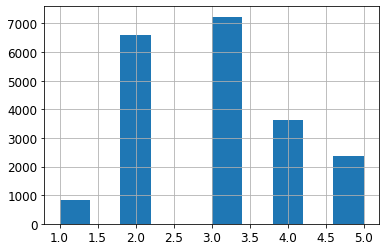

In [34]:
# suppose median_income is a strong predictor, we can split the train and test set with proportional strata
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()

In [38]:
# then we can split the data according the new categories
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.iloc[train_index]
  strat_test_set = housing.iloc[test_index]

strat_test_set['income_cat'].value_counts(normalize=True)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [41]:
def income_cat_proportions(data):
  return data['income_cat'].value_counts(normalize=True)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({'Overall': income_cat_proportions(housing),
              'Random': income_cat_proportions(test_set),
              'Stratified': income_cat_proportions(strat_test_set)}).sort_index()
compare_props['Rand.%error'] = 100*compare_props['Random']/compare_props['Overall'] - 100
compare_props['Strat.%error'] = 100*compare_props['Stratified']/compare_props['Overall'] - 100
display(compare_props)

,Overall,Random,Stratified,Rand.%error,Strat.%error
1,0.039826,0.040213,0.039729,0.973236,-0.243309
2,0.318847,0.324370,0.318798,1.732260,-0.015195
3,0.350581,0.358527,0.350533,2.266446,-0.013820
4,0.176308,0.167393,0.176357,-5.056334,0.027480
5,0.114438,0.109496,0.114583,-4.318374,0.127011


The test set generated from stratified sampling has almost identical proportions of income of full dataset, while the random sampling appears to be skewed.

In [42]:
# we need to drop the categories to make the data back to original shape
for data in strat_train_set, strat_test_set:
  data.drop('income_cat', axis=1, inplace=True)
  

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Visualisations Analysis